# Creating synthetic financial time series using Generative Adversarial Networks (GANs) parameterized by Transformers.

## Step 0: Imports.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import yfinance as yf
from sklearn import preprocessing
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

## Step 1: Collect and process training data.

Positional encoding allows the attention mechanism of the transformer to keep track of the order of observations. PyTorch uses the standard categorical embedding, but for time series the cyclical encoding is more useful. Therefore, we have to define our own cyclical encoding function and add this directly to the input. 

In [2]:
def cyclical_encodings(dates: np.ndarray) -> np.ndarray:
    """ Creates cyclical encodings of dates in a year down to hourly diff """
    start = [date(d.year, d.month, d.day) for d in dates]
    delta = np.array([(s-start[0]).days for s in start])
    hours = np.array(dates.hour / 24)
    position = np.array([2 * np.pi * (d+h) / (delta[-1]+1) for d, h in zip(delta, hours)])
    return np.array([np.sin(position), np.cos(position)])

The generator is supposed to generate synthetic time series, so that is what it is trained on. We append the cyclical encoding directly to this time series to produce the input array. 

In [3]:
def fin_time_series(ticker='AAPL', period='2y', interval='1h', cyclical_encoding=False) -> np.ndarray:
    """ Returns normalized prices with corresponding cyclical encodings """
    close_prices = yf.Ticker(ticker).history(period=period, interval=interval)['Close']
    output = preprocessing.normalize([close_prices])
    if cyclical_encoding:
        encodings = cyclical_encodings(close_prices.index)
        output = np.append(output, encodings, axis=0)
    output = np.array([*output]).T
    return output

We create a training set of 100 large cap US stocks to train the networks. 

In [4]:
tickers = ['AAL', 'AAPL', 'ABNB', 'ABT', 'ACN', 'ADBE', 'AMD', \
    'AMZN', 'AXP', 'BA', 'BAC', 'BKNG', 'BLK', 'BMY', 'BP', 'BTI', \
    'BUD', 'C', 'CAT', 'CMCSA', 'CMG', 'COP', 'COST', 'CRM', \
    'CSCO', 'CVS', 'CVX', 'DAL', 'DE', 'DELL', 'DIS', 'F', 'FDX', \
    'GE', 'GILD', 'GM', 'GOOGL', 'GS', 'HD', 'HMC', 'HON', 'HPQ', \
    'HSBC', 'HYMTF', 'IBM', 'INFY', 'INTC', 'JNJ', 'JPM', 'KO', \
    'LCID', 'LLY', 'LMT', 'LOW', 'LUV', 'MA', 'MCD', 'MDLZ', \
    'META', 'MS', 'MSFT', 'MU', 'NIO', 'NKE', 'NVDA', 'ORCL', \
    'PEP', 'PFE', 'PG', 'PLTR', 'PSNY', 'PYPL', 'QCOM', 'RACE', \
    'RIVN', 'RTX', 'RY', 'RYAAY', 'SBUX', 'SCHW', 'SHEL', 'SHOP', \
    'SNY', 'T', 'TGT', 'TM', 'TSLA', 'TSM', 'TXN', 'UAL', 'UBER', \
    'UBS', 'UL', 'UNH', 'V', 'VZ', 'WFC', 'WM', 'WMT', 'XOM']
train_data = np.array([fin_time_series(ticker=t, period='1y', interval='1d', cyclical_encoding=True) for t in tickers])
train_dataset = TensorDataset(torch.tensor(train_data))  

Here is a visualization of how cyclical encoding works. Each observation is encoded with its unique position that is close to adjacent observations. These embeddings creates this plot that kind of looks like a clock. 

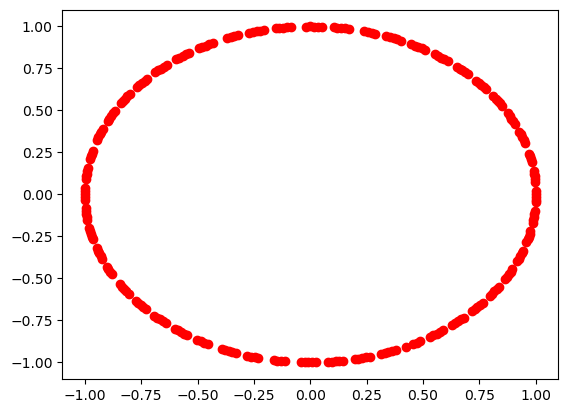

In [14]:
plt.plot(train_data[0][:, 1], train_data[0][:, 2], 'ro')
plt.show()

## Step 2: Create Generator and Discriminator.

Both the generator and discriminator is parameterized by a transformer encoder network. 

In [23]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.2):
        super(Generator, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(hidden_dim, num_heads),
            num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.do = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x = self.do(x)
        x = self.transformer_encoder(x)
        x = self.do(x)
        x = self.fc(x)
        return x

In [24]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.2):
        super(Discriminator, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(hidden_dim, num_heads),
            num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)
        self.do = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x = self.do(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        x = self.do(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

## Step 3: Train GANs.

### Step 3.1: Prepare training data.

In [20]:
batch_size = 32 
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Step 3.2: Instantiate the generator and discriminator. 

In [144]:
#generator = Generator(1, 1, 256, 3, 4)
generator = Generator(train_data.shape[-1], 1, 64, 3, 4)
discriminator = Discriminator(train_data.shape[-1], 64, 3, 4)

### Step 3.3: Define loss function (binary cross entropy) and optimizer (Adam).

In [147]:
criterion = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

### Step 3.4: Define number of training epochs.

In [113]:
num_epochs = 100

### Step 3.5: Define some variables used for visualizing performance. 

In [146]:
generator_losses = []
discriminator_losses = []
synthetic_data = []

### Step 3.5: Training loop. 

In [148]:
for epoch in range(num_epochs):
    for batch in data_loader:

        batch = batch[0]
        batch_size = batch.shape[0]
        latent_dim = batch.shape[1]
    
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        ########## Train the discriminator ########## 
        discriminator_optimizer.zero_grad()

        # Test the discriminator on real data
        real_data = batch.to(device).float()
        real_outputs = discriminator(real_data)
        real_loss = criterion(real_outputs, real_labels)

        # Generate synthetic data
        noise = torch.randn(batch_size, latent_dim, 1) # noise for generator
        noise = torch.cat((noise, real_data[0][:, 1:].unsqueeze(0).repeat(batch_size, 1, 1)), 2)
        fake_data = generator(noise) # generate synthetic time series
        fake_data = torch.cat((fake_data, real_data[0][:, 1:].unsqueeze(0).repeat(batch_size, 1, 1)), 2) #add cyclical encoding to generated time series

        # Test discriminator on fake data
        fake_outputs = discriminator(fake_data.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        # Calculate discriminator loss on real and fake data and perform backwards pass and take a step with the optimizer
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()

        ########## Train the generator ########## 
        generator_optimizer.zero_grad()
        fake_outputs = discriminator(fake_data) # Test the discriminators ability to recognize the synthetic data by the generator 
        generator_loss = criterion(fake_outputs, real_labels)
        generator_loss.backward()
        generator_optimizer.step()

    generator_losses.append(generator_loss.item())
    discriminator_losses.append(discriminator_loss.item())
    synthetic_data.append(fake_data)
    print(f"Epoch [{epoch+1}/{num_epochs}] Generator Loss: {generator_loss.item():.4f} Discriminator Loss: {discriminator_loss.item():.4f}")


Epoch [1/100] Generator Loss: 1.0980 Discriminator Loss: 1.1866
Epoch [2/100] Generator Loss: 0.6334 Discriminator Loss: 2.2295
Epoch [3/100] Generator Loss: 0.9931 Discriminator Loss: 1.4331
Epoch [4/100] Generator Loss: 0.6632 Discriminator Loss: 1.2911
Epoch [5/100] Generator Loss: 0.7652 Discriminator Loss: 1.2255
Epoch [6/100] Generator Loss: 1.3925 Discriminator Loss: 0.8617
Epoch [7/100] Generator Loss: 0.0695 Discriminator Loss: 2.8917
Epoch [8/100] Generator Loss: 0.1422 Discriminator Loss: 2.7504
Epoch [9/100] Generator Loss: 0.6382 Discriminator Loss: 1.5494
Epoch [10/100] Generator Loss: 1.2918 Discriminator Loss: 1.4534
Epoch [11/100] Generator Loss: 1.1137 Discriminator Loss: 1.3661
Epoch [12/100] Generator Loss: 1.0398 Discriminator Loss: 1.2752
Epoch [13/100] Generator Loss: 1.6559 Discriminator Loss: 0.8768
Epoch [14/100] Generator Loss: 0.3482 Discriminator Loss: 1.6034
Epoch [15/100] Generator Loss: 0.3254 Discriminator Loss: 1.6550
Epoch [16/100] Generator Loss: 0.4

### Plot generator and discriminator loss.

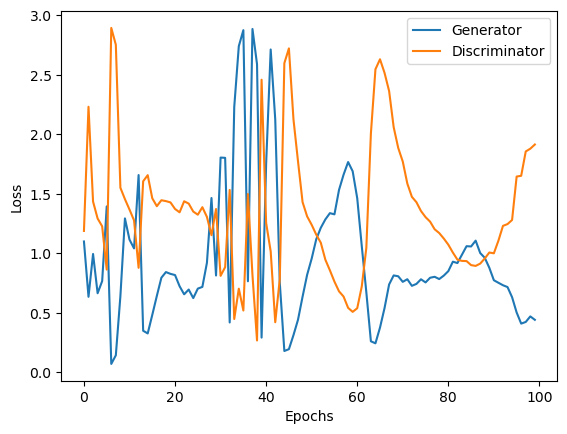

In [149]:
plt.plot(generator_losses, label='Generator')
plt.plot(discriminator_losses, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### First and last generated synthetic time series compared to a (random) real price series. 

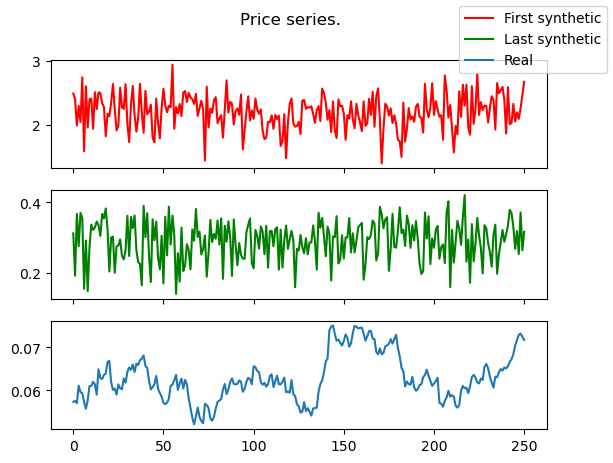

In [151]:
fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Price series.')
axs[0].plot(synthetic_data[0][0][:, 0].detach().numpy(), color='r', label='First synthetic')
axs[1].plot(synthetic_data[-1][0][:, 0].detach().numpy(), color='g', label='Last synthetic')
axs[2].plot(train_data[0][:, 0], label='Real')
fig.legend()

for ax in axs:
    ax.label_outer()